In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor

## 1. Найти функцию, описывающую выбросы парниковых газов.

$$ y = a\exp^{bx} \Rightarrow \ln(y) = \ln(a) + bx$$

In [2]:
# df = pd.read_csv("ghg-emissions-by-gas.csv").rename(
# 	columns={
# 		"Annual nitrous oxide emissions in CO₂ equivalents": "N2O",
# 		"Annual methane emissions in CO₂ equivalents": "CH4",
# 		"Annual CO₂ emissions": "CO2",
# 	}
# )
# df

In [3]:
df = pd.read_csv(
	"https://ourworldindata.org/grapher/ghg-emissions-by-gas.csv?v=1&csvType=full&useColumnShortNames=true", 
	storage_options = {
		"User-Agent": "Our World In Data data fetch/1.0"
	}
).rename(
	columns={
		"annual_emissions_n2o_total_co2eq": "N2O",
		"annual_emissions_ch4_total_co2eq": "CH4",
		"annual_emissions_co2_total": "CO2",
	}
)

df

,entity,code,year,N2O,CH4,CO2
0,Afghanistan,AFG,1850,223490.36,3594926.2,3726385.8
1,Afghanistan,AFG,1851,228148.10,3615134.2,3765053.0
2,Afghanistan,AFG,1852,232685.88,3635346.8,3800325.2
3,Afghanistan,AFG,1853,237029.45,3655563.5,3835169.8
4,Afghanistan,AFG,1854,241104.60,3675785.0,3869025.2
...,...,...,...,...,...,...
41470,Zimbabwe,ZWE,2020,4591432.50,11314008.0,8240392.5
41471,Zimbabwe,ZWE,2021,4857637.50,11840276.0,11208613.0
41472,Zimbabwe,ZWE,2022,5201800.00,12642957.0,12072071.0
41473,Zimbabwe,ZWE,2023,5245372.00,12999134.0,12784178.0


In [4]:
sum_year = df.groupby("year", dropna=True)[["N2O", "CH4", "CO2"]].sum()
sum_year

,N2O,CH4,CO2
year,,,
1850,7.591512e+08,6.487692e+09,1.556824e+10
1851,7.726909e+08,6.512196e+09,1.608972e+10
1852,7.859377e+08,6.550729e+09,1.666067e+10
1853,7.987105e+08,6.594780e+09,1.678429e+10
1854,8.108278e+08,6.673820e+09,1.727308e+10
...,...,...,...
2020,1.397489e+10,4.305360e+10,1.889702e+11
2021,1.417022e+10,4.393502e+10,1.977445e+11
2022,1.405463e+10,4.476436e+10,2.003382e+11


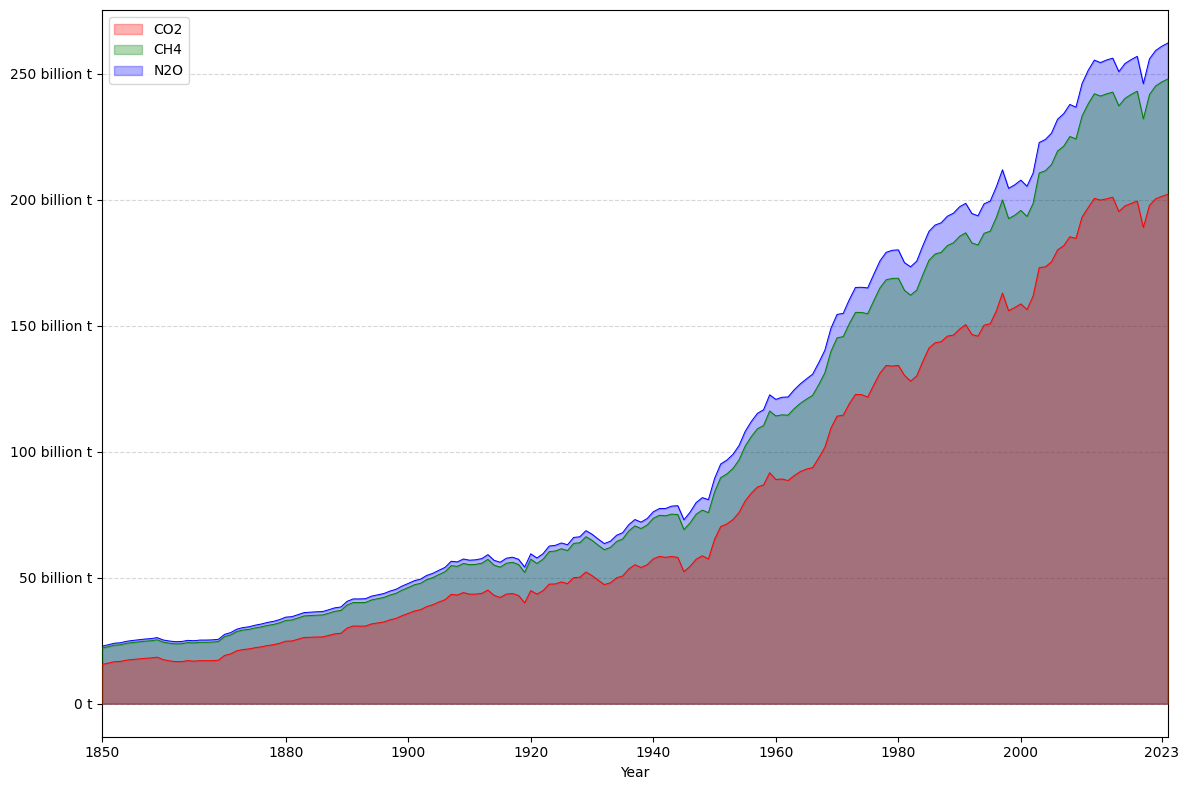

In [5]:
plt.figure(figsize=(12, 8))

plt.fill_between(sum_year.index, 0, sum_year["CO2"], alpha=.3, color="red", label="CO2", zorder=4)
plt.fill_between(sum_year.index, 0, sum_year["CH4"] + sum_year["CO2"], alpha=.3, color="green", label="CH4", zorder=3)
plt.fill_between(sum_year.index, 0, sum_year["N2O"] + sum_year["CH4"] + sum_year["CO2"], alpha=.3, color="blue", label="N2O", zorder=2)

plt.plot(sum_year.index, sum_year["CO2"], lw=.7, color="red", zorder=4)
plt.plot(sum_year.index, sum_year["CH4"] + sum_year["CO2"], lw=.7, color="green", zorder=3)
plt.plot(sum_year.index, sum_year["N2O"] + sum_year["CH4"] + sum_year["CO2"], lw=.7, color="blue", zorder=2)

plt.xlabel("Year")
plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
plt.yticks(
	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
)

plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [6]:
x = df[df["year"] <= 1980].groupby("year", dropna=True)[["N2O", "CH4", "CO2"]].sum()
y = df[df["year"] >= 1980].groupby("year", dropna=True)[["N2O", "CH4", "CO2"]].sum()

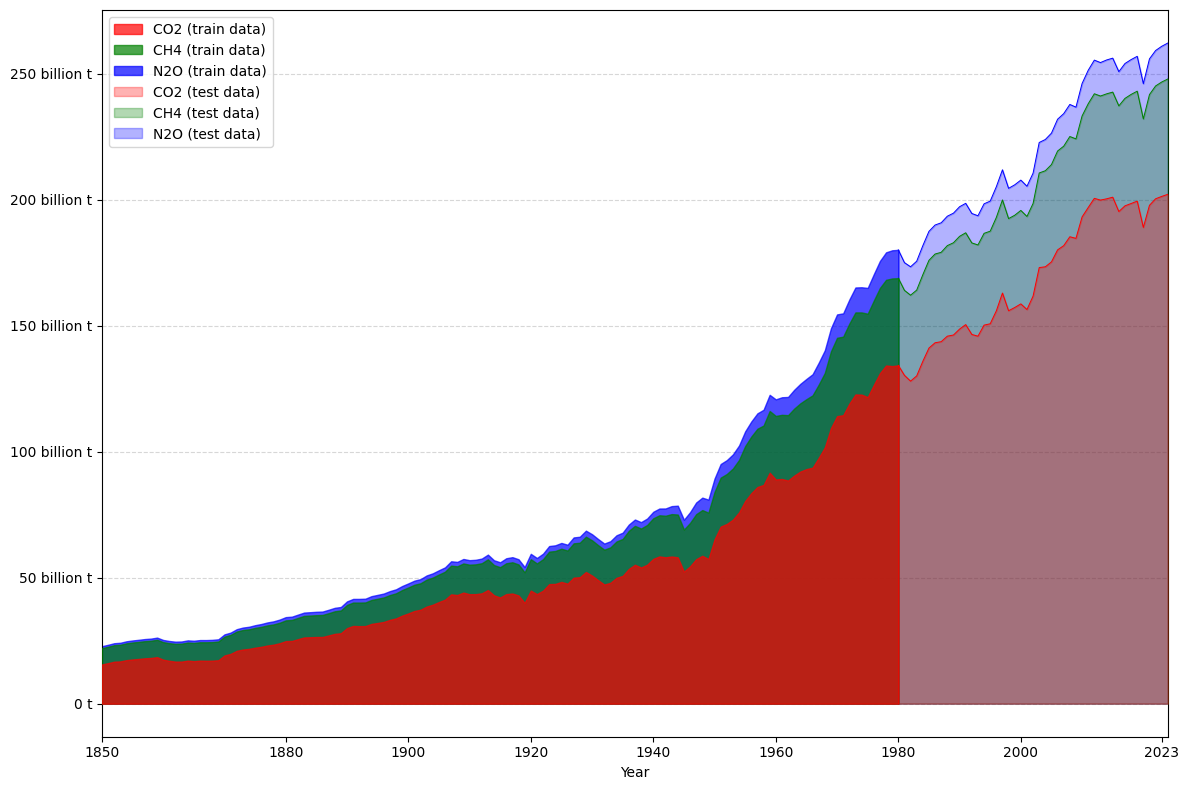

In [7]:
plt.figure(figsize=(12, 8))

plt.fill_between(x.index, 0, x["CO2"], alpha=.7, color="red", label="CO2 (train data)", zorder=4)
plt.fill_between(x.index, 0, x["CH4"] + x["CO2"], alpha=.7, color="green", label="CH4 (train data)", zorder=3)
plt.fill_between(x.index, 0, x["N2O"] + x["CH4"] + x["CO2"], alpha=.7, color="blue", label="N2O (train data)", zorder=2)


plt.fill_between(y.index, 0, y["CO2"], alpha=.3, color="red", label="CO2 (test data)", zorder=4)
plt.fill_between(y.index, 0, y["CH4"] + y["CO2"], alpha=.3, color="green", label="CH4 (test data)", zorder=3)
plt.fill_between(y.index, 0, y["N2O"] + y["CH4"] + y["CO2"], alpha=.3, color="blue", label="N2O (test data)", zorder=2)

# plt.plot(x.index, x["CO2"], lw=.7, color="red", zorder=4)
# plt.plot(x.index, x["CH4"] + x["CO2"], lw=.7, color="green", zorder=3)
# plt.plot(x.index, x["N2O"] + x["CH4"] + x["CO2"], lw=.7, color="blue", zorder=2)

plt.plot(y.index, y["CO2"], lw=.7, color="red", zorder=4)
plt.plot(y.index, y["CH4"] + y["CO2"], lw=.7, color="green", zorder=3)
plt.plot(y.index, y["N2O"] + y["CH4"] + y["CO2"], lw=.7, color="blue", zorder=2)


plt.xlabel("Year")
plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
plt.yticks(
	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
)

plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [8]:
x_data, y_data = x.sum(1), y.sum(1)

x_train, x_test = x_data.index.to_frame(), y_data.index.to_frame()
y_train, y_test = x_data.values, y_data.values
	
model = LinearRegression().fit(x_train, np.log(y_train))
pred_train = np.exp(model.predict(x_train))
pred_test = np.exp(model.predict(x_test))

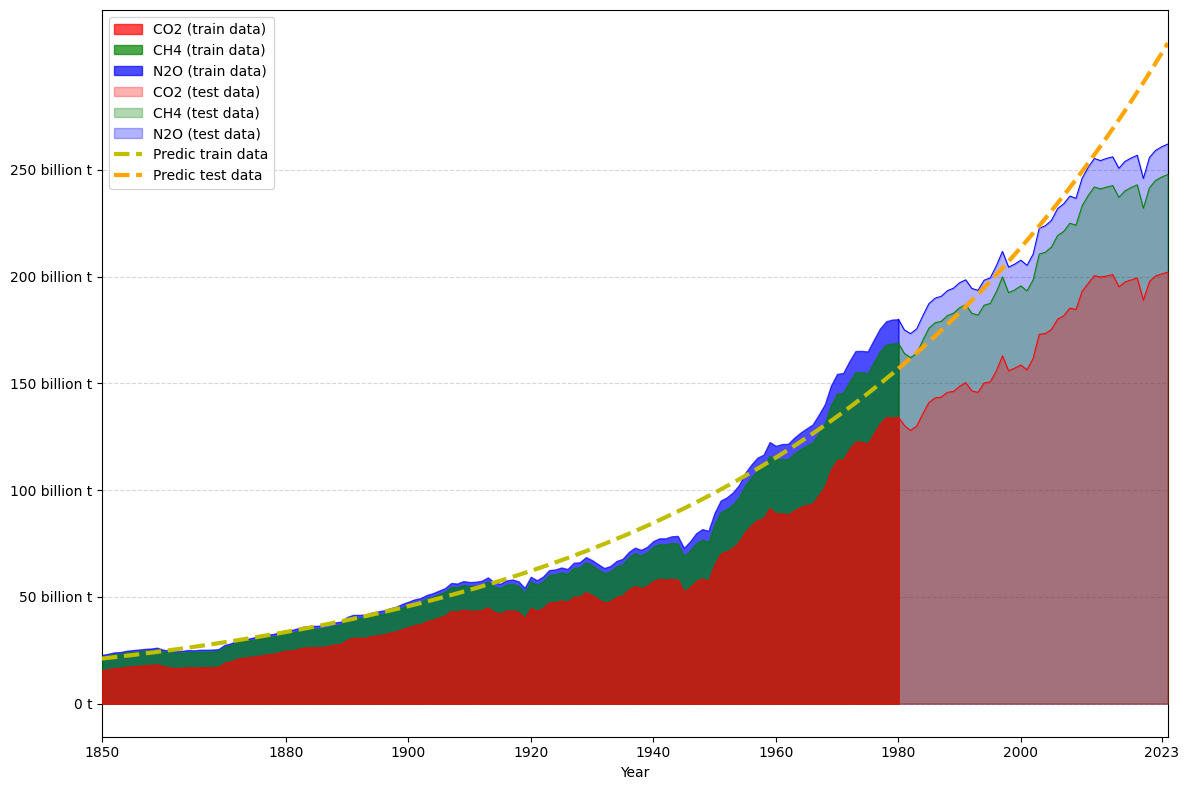

In [9]:
plt.figure(figsize=(12, 8))

plt.fill_between(x.index, 0, x["CO2"], alpha=.7, color="red", label="CO2 (train data)", zorder=4)
plt.fill_between(x.index, 0, x["CH4"] + x["CO2"], alpha=.7, color="green", label="CH4 (train data)", zorder=3)
plt.fill_between(x.index, 0, x["N2O"] + x["CH4"] + x["CO2"], alpha=.7, color="blue", label="N2O (train data)", zorder=2)


plt.fill_between(y.index, 0, y["CO2"], alpha=.3, color="red", label="CO2 (test data)", zorder=4)
plt.fill_between(y.index, 0, y["CH4"] + y["CO2"], alpha=.3, color="green", label="CH4 (test data)", zorder=3)
plt.fill_between(y.index, 0, y["N2O"] + y["CH4"] + y["CO2"], alpha=.3, color="blue", label="N2O (test data)", zorder=2)

# plt.plot(x.index, x["CO2"], lw=.7, color="red", zorder=4)
# plt.plot(x.index, x["CH4"] + x["CO2"], lw=.7, color="green", zorder=3)
# plt.plot(x.index, x["N2O"] + x["CH4"] + x["CO2"], lw=.7, color="blue", zorder=2)

plt.plot(y.index, y["CO2"], lw=.7, color="red", zorder=4)
plt.plot(y.index, y["CH4"] + y["CO2"], lw=.7, color="green", zorder=3)
plt.plot(y.index, y["N2O"] + y["CH4"] + y["CO2"], lw=.7, color="blue", zorder=2)


plt.plot(x.index, pred_train, label="Predic train data", zorder=6, ls="--", lw=3, c="y")
plt.plot(y.index, pred_test, label="Predic test data", zorder=6, ls="--", lw=3, c="orange")


plt.xlabel("Year")
plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
plt.yticks(
	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
)

plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [10]:
print(
	f"R2 train: {r2_score(y_train, pred_train)}",
	f"R2 train: {r2_score(y_test, pred_test)}",
	f"MAE train: {mean_absolute_error(y_train, pred_train)}",
	f"MAE test: {mean_absolute_error(y_test, pred_test)}",
	sep="\n"
)

R2 train: 0.9588653518044532
R2 train: 0.5707262356929759
MAE train: 5654855226.444623
MAE test: 13952211259.857718


## 2. Найти функцию, описывающую количество пассажиров некоторой

In [11]:
df = pd.read_csv("files/airline_passengers.csv")
df

,Month,Passengers
0,1/1/1949,112
1,1/2/1949,118
2,1/3/1949,132
3,1/4/1949,129
4,1/5/1949,121
...,...,...
139,1/8/1960,606
140,1/9/1960,508
141,1/10/1960,461
142,1/11/1960,390


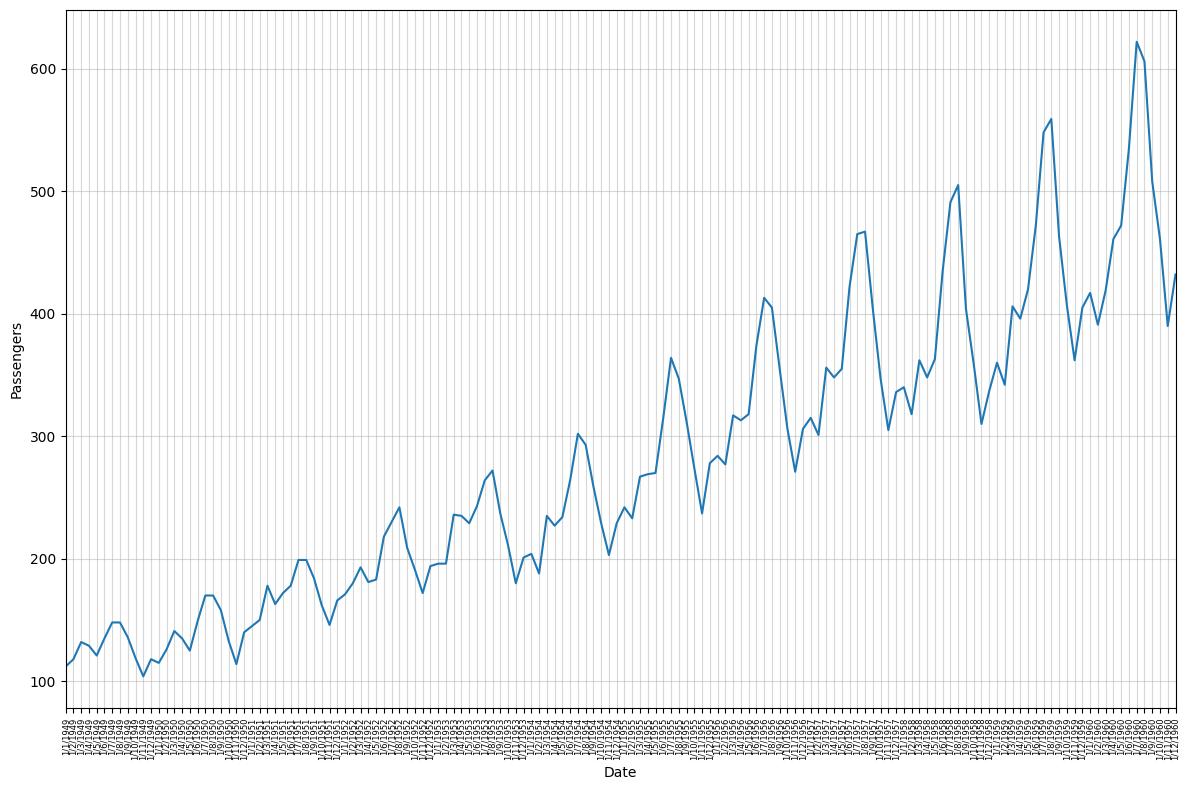

In [12]:
plt.figure(figsize=(12, 8))

plt.plot(df["Month"], df["Passengers"])

plt.xlabel("Date")
plt.ylabel("Passengers")

plt.xticks(rotation=90, fontsize=6)

plt.grid(alpha=.5)

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [13]:
df["date"] = pd.to_datetime(df["Month"], format="%d/%m/%Y")
df["monthofyear"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df

,Month,Passengers,date,monthofyear,year
0,1/1/1949,112,1949-01-01,1,1949
1,1/2/1949,118,1949-02-01,2,1949
2,1/3/1949,132,1949-03-01,3,1949
3,1/4/1949,129,1949-04-01,4,1949
4,1/5/1949,121,1949-05-01,5,1949
...,...,...,...,...,...
139,1/8/1960,606,1960-08-01,8,1960
140,1/9/1960,508,1960-09-01,9,1960
141,1/10/1960,461,1960-10-01,10,1960
142,1/11/1960,390,1960-11-01,11,1960


In [14]:
df["cos_monthofyear"] = np.cos(2 * np.pi * (df["monthofyear"] - 1) / 12)
df["sin_monthofyear"] = np.sin(2 * np.pi * (df["monthofyear"] - 1) / 12)

In [15]:
df

,Month,Passengers,date,monthofyear,year,cos_monthofyear,sin_monthofyear
0,1/1/1949,112,1949-01-01,1,1949,1.000000e+00,0.000000
1,1/2/1949,118,1949-02-01,2,1949,8.660254e-01,0.500000
2,1/3/1949,132,1949-03-01,3,1949,5.000000e-01,0.866025
3,1/4/1949,129,1949-04-01,4,1949,6.123234e-17,1.000000
4,1/5/1949,121,1949-05-01,5,1949,-5.000000e-01,0.866025
...,...,...,...,...,...,...,...
139,1/8/1960,606,1960-08-01,8,1960,-8.660254e-01,-0.500000
140,1/9/1960,508,1960-09-01,9,1960,-5.000000e-01,-0.866025
141,1/10/1960,461,1960-10-01,10,1960,-1.836970e-16,-1.000000
142,1/11/1960,390,1960-11-01,11,1960,5.000000e-01,-0.866025


In [16]:
x, y = df[df["date"] <= "1956-12-01"], df[df["date"] >= "1956-12-01"]

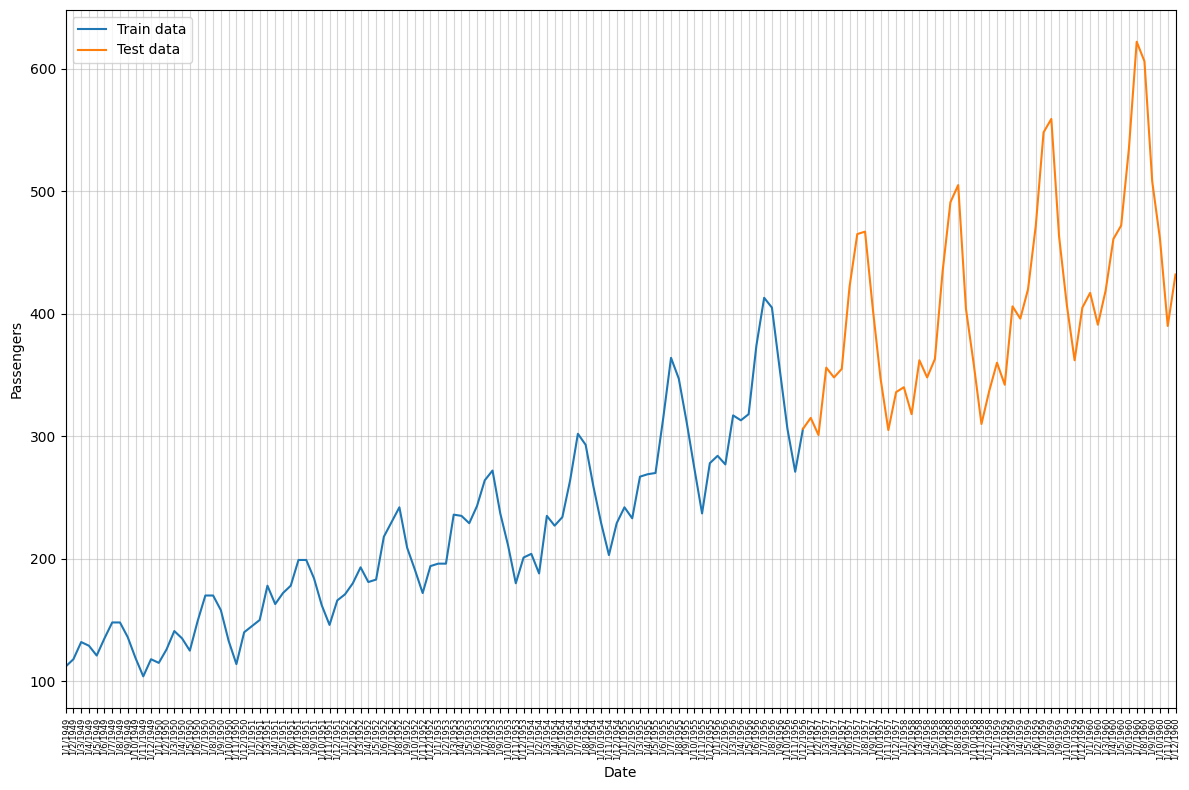

In [17]:
plt.figure(figsize=(12, 8))

plt.plot(x["Month"], x["Passengers"], label="Train data")
plt.plot(y["Month"], y["Passengers"], label="Test data")

plt.xlabel("Date")
plt.ylabel("Passengers")

plt.xticks(rotation=90, fontsize=6)

plt.legend()
plt.grid(alpha=.5)

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [18]:
x_train, x_test = x[["cos_monthofyear", "year"]], y[["cos_monthofyear", "year"]]
y_train, y_test = x["Passengers"].to_frame(), y["Passengers"].to_frame()

In [19]:
LinearRegression_model = LinearRegression().fit(
	x_train,
	y_train
)

y_pred_train = LinearRegression_model.predict(x_train)
y_pred_test = LinearRegression_model.predict(x_test)

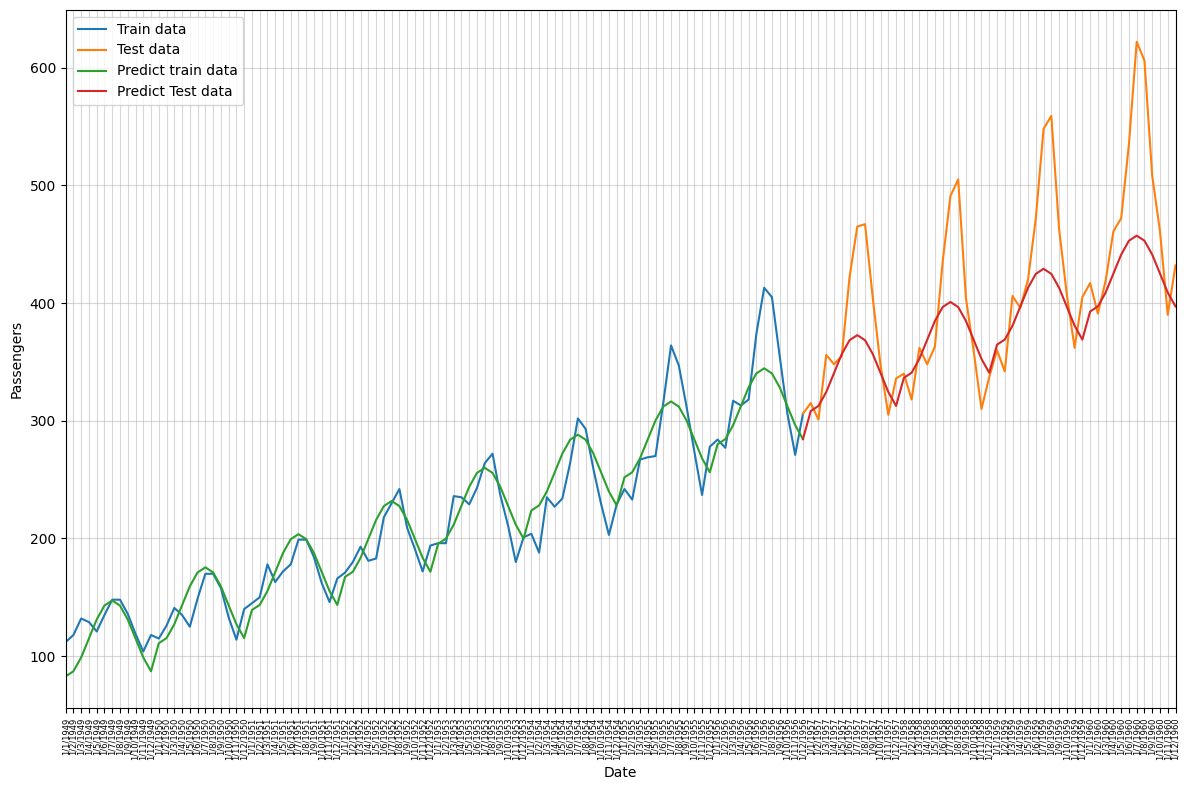

In [20]:
plt.figure(figsize=(12, 8))

plt.plot(x["Month"], y_train, label="Train data")
plt.plot(y["Month"], y_test, label="Test data")
plt.plot(x["Month"], y_pred_train, label="Predict train data")
plt.plot(y["Month"], y_pred_test, label="Predict Test data")


plt.xlabel("Date")
plt.ylabel("Passengers")

plt.xticks(rotation=90, fontsize=6)

plt.legend()
plt.grid(alpha=.5)

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [21]:
print(
	f"R2: {LinearRegression_model.score(x_train, y_train)}",
	sep="\n"
)

R2: 0.9159058117983518


## 3. Спрогнозировать численность населения Земли в 2027 году.

In [22]:
df = pd.read_csv(
	"https://ourworldindata.org/grapher/population.csv?v=1&csvType=full&useColumnShortNames=true", 
	storage_options = {
		"User-Agent": "Our World In Data data fetch/1.0"
	}
)
df

,entity,code,year,population_historical
0,Afghanistan,AFG,-10000,14737
1,Afghanistan,AFG,-9000,20405
2,Afghanistan,AFG,-8000,28253
3,Afghanistan,AFG,-7000,39120
4,Afghanistan,AFG,-6000,54166
...,...,...,...,...
58819,Zimbabwe,ZWE,2019,15271377
58820,Zimbabwe,ZWE,2020,15526887
58821,Zimbabwe,ZWE,2021,15797220
58822,Zimbabwe,ZWE,2022,16069061


In [23]:
sum_year = df.groupby("year", dropna=True)[["population_historical"]].sum()
sum_year

,population_historical
year,
-10000,18806932
-9000,23704932
-8000,30405190
-7000,39991801
-6000,54840519
...,...
2019,40519323090
2020,40904827842
2021,41246730592


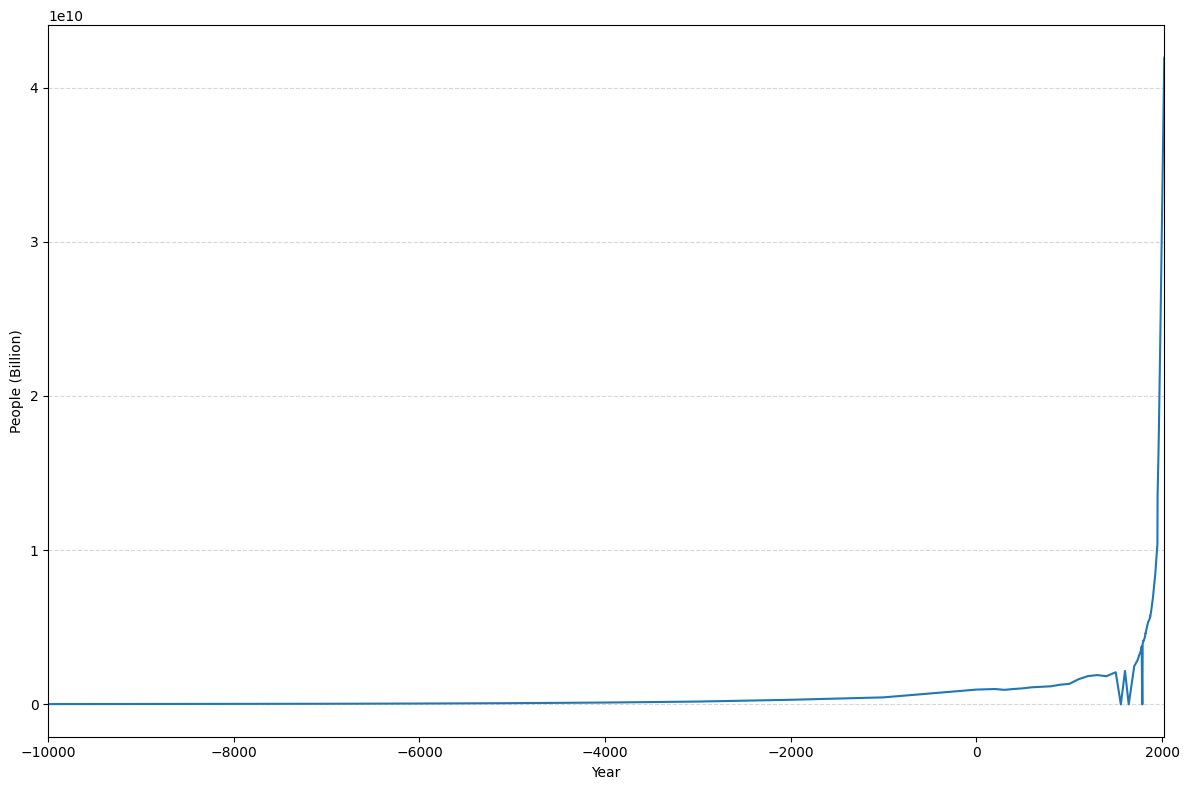

In [24]:
plt.figure(figsize=(12, 8))

plt.plot(sum_year.index, sum_year["population_historical"])

plt.xlabel("Year")
plt.ylabel("People (Billion)")
# plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
# plt.yticks(
# 	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
# 	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
# )

plt.grid(axis="y", alpha=.5, ls="--")
# plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [25]:
x = df[df["year"] <= 1805].groupby("year", dropna=True)["population_historical"].sum()
y = df[df["year"] >= 1804].groupby("year", dropna=True)["population_historical"].sum()

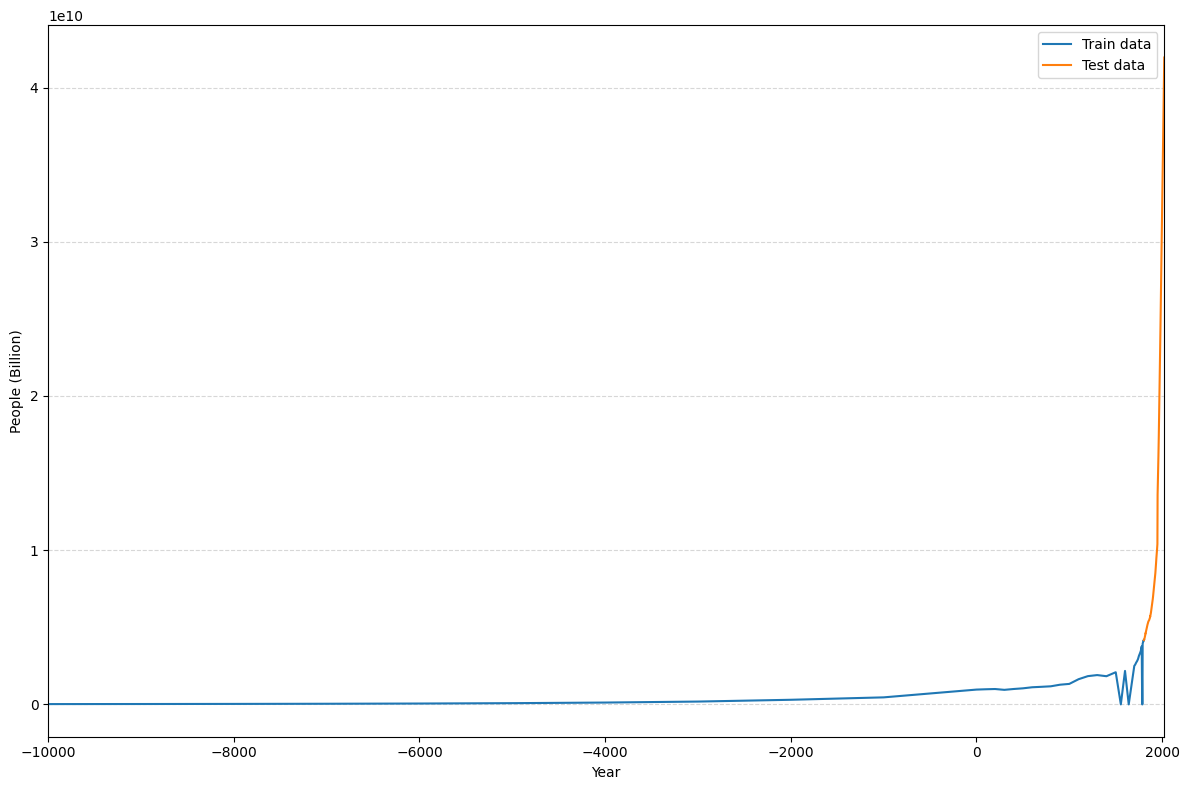

In [26]:
plt.figure(figsize=(12, 8))

plt.plot(x.index, x, label="Train data")
plt.plot(y.index, y, label="Test data")

plt.xlabel("Year")
plt.ylabel("People (Billion)")
# plt.xticks([1850] + [sum_year.index[i] for i in range(30, len(sum_year.index) - 20, 20)] + [2023])
# plt.yticks(
# 	[i for i in range(0, 300_000_000_000, 50_000_000_000)],
# 	[f"{i} billion t" if i != 0 else "0 t" for i in range(0, 300, 50)]
# )

plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [27]:
x_data, y_data = x, y

x_train, x_test = x_data.index.to_frame(), y_data.index.to_frame()
y_train, y_test = x_data.values, y_data.values
	
model = LinearRegression().fit(x_train, np.log(y_train))
pred_train = np.exp(model.predict(x_train))
pred_test = np.exp(model.predict(x_test))

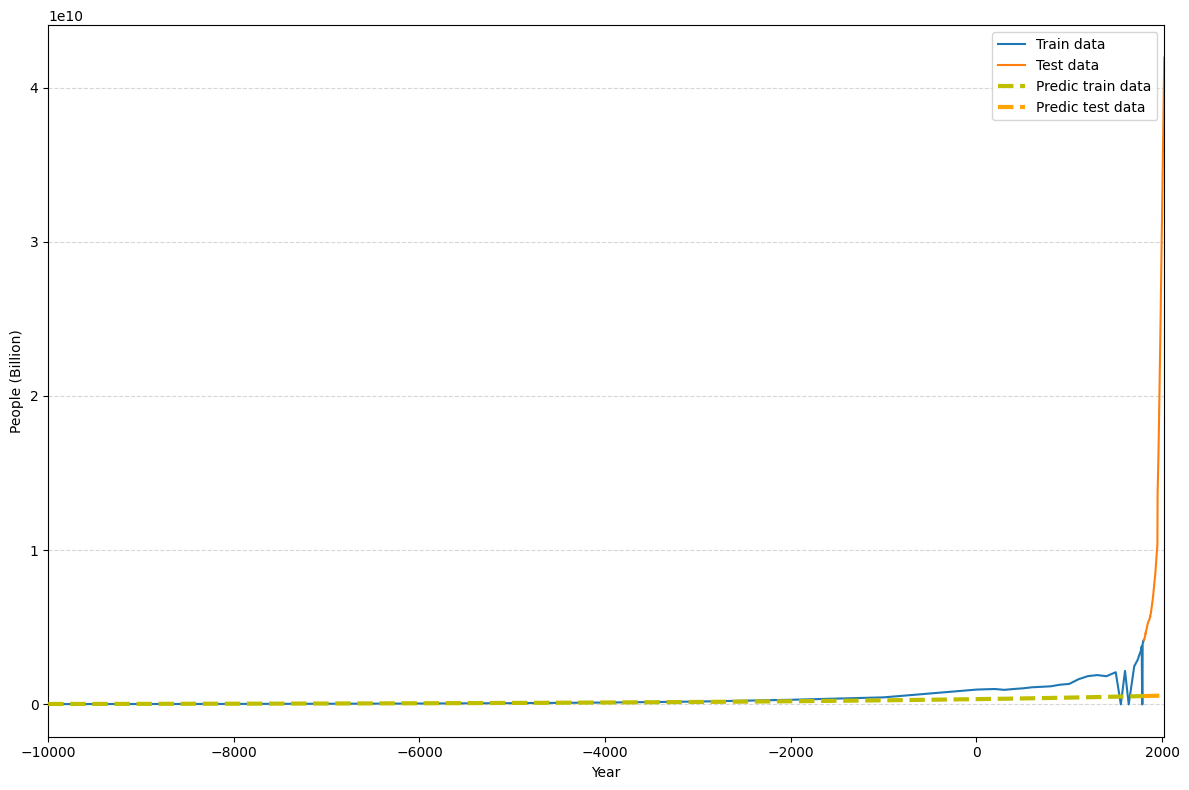

In [28]:
plt.figure(figsize=(12, 8))

plt.plot(x.index, x, label="Train data")
plt.plot(y.index, y, label="Test data")

plt.plot(x.index, pred_train, label="Predic train data", zorder=6, ls="--", lw=3, c="y")
plt.plot(y.index, pred_test, label="Predic test data", zorder=6, ls="--", lw=3, c="orange")

plt.xlabel("Year")
plt.ylabel("People (Billion)")


plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [29]:
f"Прогноз на 2027 год - {np.exp(model.predict([[2027]]))[0]:,}"

c:\Users\ebeck\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


'Прогноз на 2027 год - 572,135,614.6197827'

In [30]:
print(
	f"R2 train: {r2_score(y_train, pred_train)}",
	f"R2 train: {r2_score(y_test, pred_test)}",
	f"MAE train: {mean_absolute_error(y_train, pred_train)}",
	f"MAE test: {mean_absolute_error(y_test, pred_test)}",
	sep="\n"
)

R2 train: -0.6698506974912386
R2 train: -1.3475953344346303
MAE train: 1409860158.6996377
MAE test: 12722018831.243752


In [31]:
x_data, y_data = sum_year.index.to_frame(), sum_year.values
	
model = LinearRegression().fit(x_data, np.log(y_data))
pred = np.exp(model.predict(x_data))

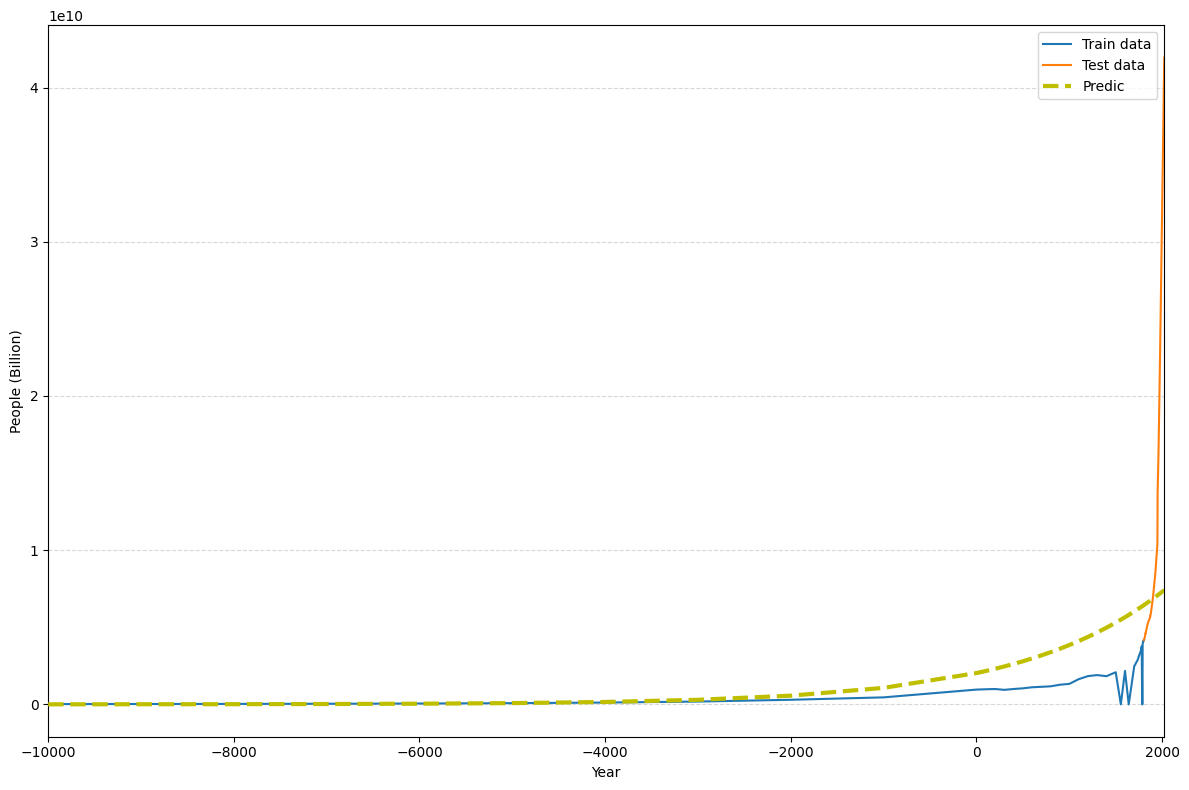

In [32]:
plt.figure(figsize=(12, 8))

plt.plot(x.index, x, label="Train data")
plt.plot(y.index, y, label="Test data")

plt.plot(x_data, pred, label="Predic", zorder=6, ls="--", lw=3, c="y")

plt.xlabel("Year")
plt.ylabel("People (Billion)")


plt.grid(axis="y", alpha=.5, ls="--")
plt.legend()

plt.margins(x=0)

plt.tight_layout()
plt.show()

In [33]:
f"Прогноз на 2027 год - {np.exp(model.predict([[2027]]))[0][0]:,}"

c:\Users\ebeck\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


'Прогноз на 2027 год - 7,426,732,933.05083'

In [34]:
print(
	f"R2: {r2_score(y_data, pred)}",
	f"MAE: {mean_absolute_error(y_data, pred)}",
	sep="\n"
)

R2: -0.0923364931666888
MAE: 6602323419.638767


In [35]:
# При деление данных на тестовую и тренировочную выборку - ошибка получается очень большая.
# Если же оставить данные в обычном состояние, то получается и более лучшая апроксимация